# 1 引言
集成学习算法是当下炙手可热的一类算法，在诸多机器学习大赛中都频繁出现它的身影。准确来说，集成学习算法并不是一个单独的机器学习算法，而是通过构建多个学习器，博采众家之长，共同求解问题的一种思想。古语有云：“三个臭皮匠顶个诸葛亮”。一个简单的学习器也许不能很好的拟合数据，但是结合多个不同的学习器去解决问题，往往就可能有更加不俗的表现。
本篇博文中，我们先来详细说说集成学习思想以及分类，然后对其中的Bagging算法展开介绍。

# 2 集成学习
引言中说过，所谓集成学习就是先产生一组单个的学习器，我们姑且将这些单个的学习器称为“个体学习器”，然后通过某种策略将这些个体学习器结合起来共同完成学习任务，如下图所示。那么，有两个问题需要解决：第一，如果获得个体学习器；第二，如何将各个体学习器的结果结合到一起。  

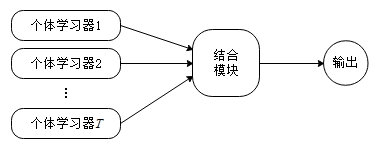

在回答第一个问题前，我们必须明确，对集成学习中单个学习器必须满足两个条件：  
（1）学习器之间应该有差异性。如果使用的单个学习器将没有差异，那么集成起来的结果是没有变化的。  
（2）每个学习器的精度必须大于0.5。在集成学习中，单个分类器不需要很强，因为越强的分类器训练过程就越复杂，甚至容易发生过拟合，只需要保证每个学习器准确率大于0.5，因为如果单个学习的的准确率小于0.5，随着集成规模的增加，分类精度不断下降，反之如果精度大于0.5，就算简单的学习器，通过足够数量的组合最终精度也会可以趋向于1。可以通过下图来理解这两个条件。
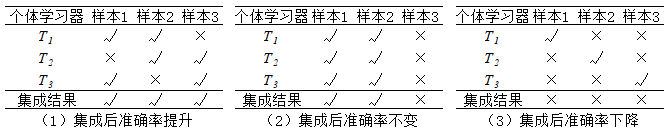

在这两个条件前提下，对于第一个问题，有两种解决思路。一种是使用不同类别的算法来构建个体学习器，例如对于同一个任务分别使用决策树算法、支持向量机、神经网络等不同算法来构建学习器。另一种思路是所有个体学习器都使用同一种算法进行构建，这种思路是目前集成学习算法的主流。在所有个体学习器都使用同种算法构建时，如何保证学习器之间的差异性呢？有两种方案：
- 每次训练个体学习器时，对原始数据集进行抽样获得不同数据集作为当前训练集，每一个训练样本在抽样训练集中可以多次或不出现，经过$T$次训练后，可得到$T$个不同的没有相互依赖的个体学习器学习器。Bagging、随机森林就是这种方案的代表。
- 通过更新权重的方式不断地使用一个弱学习器弥补前一个弱学习器的“不足”的过程，来串行地构造一个较强的学习器，这个强学习器能够使目标函数值足够小。这一方案的代表是Boosting系列的算法，包括Adaboost、GBDT、XGBOOST等

在本文中，我们先对第一种方案的两种算法——Bagging和随机森林进行介绍，在后续的博文中，再对Adaboost、GBDT等算法进行分析。

# 3 Bagging
Bagging是并行式集成学习方法的最典型代表，算法名称来源于Bootstrap aggregating的简写，又称装袋算法，这种算法直接采用自助采样法获得$T$个各不相同的数据集，分别使用这$T$个数据集进行训练可获得$T$个个体学习器，再将这些学习器组合起来共同完成分类或者回归任务。当完成分类任务时，采用简单投票法对$T$个体学习器结果进行组合后输出；当染成回归任务时，采用简单平均法对$T$个个体学习器学习结果进行组合输出。

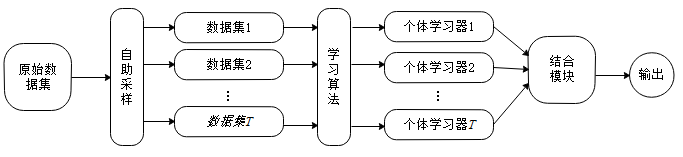

## 3.1 自助采样法
自助采样法（Bootstrap sampling是一种从给定原始数据集中有放回的均匀抽样，也就是说，每当选中一个样本，它等可能地被再次选中并被再次添加到训练集中。对于给定包含$m$个样本的原始数据集$D$，进行自助采样获得$D'$，具体操作方式：每次采样时，从几何$D$中随机抽取一个样本拷贝一份到集合$D'$中，然后将样本放回集合$D$中，是的该羊被后续采样中仍有可能被采集到；重复这一步骤$m$次后，就可以获得同样包含$m$个样本的集合$D'$，集合$D'$就是自助采样的最终结果。可以想象，集合$D$中的样本有一部分会在集合$D'$中出现重复出现，而有些样本却一次都不出现。在$m$次抽样中，某个样本从未被抽到的概率为${(1 - \frac{1}{m})^m}$，当集合$D$样本足够多时有：
$$\mathop {\lim }\limits_{m \to \infty } {(1 - \frac{1}{m})^m} = \frac{1}{e} \approx 0.368$$
也就是说，原始集合$D$中有36.8%的样本不包含在通过自助采样法获得的集合$D'$中。在Bagging中，未被采集到的36.8%的样本可以用作测试集对个体学习器性能进行评估，当个体学习器使用决策树算法构建时，这部分用本可以用来辅助树剪枝；使用神经网络构建个体学习器时，可以用来防止过拟合。

## 3.2 结合策略
假设共有$T$个个体学习器，以$\{ {h_1},{h_2}, \cdots ,{h_T}\} $表示，其中样本$x$经$h_i$后的输出值为$h_i(x)$。对于结合$T$个个体学习器输出值，主要有一下几种策略：

**（1）平均法**
平均法常用于回归类任务的数值型输出，包括简单平均法、加权平均法等。
- **简单平均法**
$$H(x) = \frac{1}{T}\sum\limits_{i = 1}^T {{h_i}(x)} $$
- **加权平均法**
$$H(x) = \sum\limits_{i = 1}^T {{w_i}{h_i}(x)} $$
式中，$w_i$是个体学习器$h_i$的权重，通常要求${w_i} \geqslant 0$且$\sum\limits_{i = 1}^T {{w_i}}  = 1$。至于$w_i$的具体值，可以根据$h_i$的具体表现来确定，$h_i$准确率越高，$w_i$越大。  
对于两种平均法的选择上，当个体学习器性能相差较大时，选用加权平均法；当各个体学习器性能相近时，使用简单加权平均法。


**（2）投票法**  
投票法更多用于作为分类任务的集成学习的结合策略。
- **相对多数投票法**
也可以认为是多数决策法，即预测结果中票数最高的分类类别。如果不止一个类别获得最高票，则随机选择一个作为最终类别。
- **绝对多数投票法**
不光要求获得票数最高，而且要求票数过半，否则决绝输出。
- **加权投票法**
与加权平均法类似，每个个体学习器的分类票数要乘以一个权重，最终将各个类别的加权票数求和，最大的值对应的类别为最终类别。


**（3）学习法**  
学习法是一种比平均法和投票法更为强大复杂的结合策略，学习法以所有个体学习器的输出作为一个数据集，额外使用一个学习器对该数据及进行学习，然后输出最终的结果。Stacking方法是学习法的一个经典代表，目前大多数应用中所说的学习法都是指Stacking方法。甚至因为Stacking方法的特殊性和复杂性，很多资料中将Stacking方法当做是与Bagging和Boosting一样的一类集成学习算法。  
Stacking方法中将之前提到的所有个体学习器称为初级学习器，将用于结合的学习器称为次级学习器。Stacking方法先从原始数据集训练处初级学习器，然后“生成”一个新的数据集用于训练次级学习器。在新的数据集中，初级学习器的输出被当做样本输出特征，而初始样本的类别标签人被当做新数据及的类别标签。（注：关于Stacking可以参考[这篇博客](https://www.cnblogs.com/wqbin/p/11634111.html)）


# 4 随机森林


## 4.1 算法介绍

随机森林（Random Forest，建成RF）也是一种十分流行的算法，原理与Bagging非常相似，甚至有很多资料认为随机森林是Bagging的一个分支，一个扩展变体。如果已经理解了Bagging算法，那么现在再来看随机森林将再将单不过。  
从名称上可以推测，随机森林是以决策树为学习算法构建个体学习器并采用Bagging思想集成的一种算法。确实也是如此，但却不止如此，因为随机森林在构建决策时，不仅在样本选择上进行了随机采样，同时在特征属性的选择上也进行了随机选取。在之前介绍决策树算法的博客中说过，传统的决策树算法在选择最优特征属性时总是从当前数据集所有特征属性（假设共有$d$个特征属性）中选择一个最优的特征属性作为当前树节点对数据集进行划分；但在随机森林中，使用决策树算法构建个体学习器时，先从$d$个属性中随机选择$k$个组成新的训练集，选择最优分裂属性时，从这$k$个属性中进行择优选取。这就是随机森林中构建决策树与传统决策树的不同。  

需要注意，有两个因素对随机森林性能影响很大：
- 森林中任意两棵树的相关性：相关性越大，错误率越大；
- 森林中每棵树的分类能力：每棵树的分类能力越强，整个森林的错误率越低  

$k$控制了选择特征训练集的随机程度，无论是相关性还是分类能力，都与$k$值选取息息相关，减小特征选择个数$k$，树的相关性和分类能力也会相应的降低；增大$k$，两者也会随之增大。所以关键问题是如何选择最优的m（或者是范围），这也是随机森林唯一的一个参数。当$k=d$时，与传统的决策树算法就没有什么区别了，都是从原始完整的训练集中进行选择，当$k=1$时，则是随机选择一个特征属性进行训练；一般情况下，推荐$k = {\log _2}d$。  

随机森林不仅在每个个体学习器训练样本选择上，延用了Bagging算法中的自助采样法，保证了每个个体学习器训练集的差异性，同时也通过特征属性的选择，进一步进行扰动，保证了个体信息器的多样性，这也是随机森林在众多集成算法中表现突出的原因。  最后总结一下随机森林的优缺点：  

优点：  
（1） 每棵树都选择部分样本及部分特征，一定程度避免过拟合；  
（2） 每棵树随机选择样本并随机选择特征，使得具有很好的抗噪能力，性能稳定；  
（3） 能处理很高维度的数据，并且不用做特征选择；  
（4） 适合并行计算；  
（5） 实现比较简单；  
缺点：  
（1）当随机森林中的决策树个数很多时，训练时需要的空间和时间会较大；  
（2）随机森林模型还有许多不好解释的地方，有点算个黑盒模型。  

  

## 4.2 代码实现

为了方便展示，还是使用自定义的二维数据集：

In [43]:
import numpy as np
import matplotlib.pyplot as plt 
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


a = np.random.normal(20,5,300)
b = np.random.normal(15,5,300)
c = np.random.normal(20,5,300)
cluster1 = np.array([[x, y, z, 1] for x, y, z in zip(a,b, c)])

a = np.random.normal(20,5,300)
b = np.random.normal(45,5,300)
c = np.random.normal(45,5,300)
cluster2 = np.array([[x, y, z, 2] for x, y, z in zip(a,b,c)])

a = np.random.normal(55,5,300)
b = np.random.normal(30,5,300)
c = np.random.normal(45,5,300)
cluster3 = np.array([[x, y, z, 3] for x, y, z in zip(a,b,c)])

dataset = np.append(np.append(cluster1,cluster2, axis=0),cluster3, axis=0)


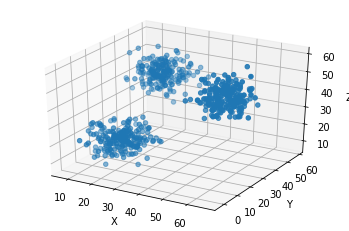

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train,x_test,y_train,y_test = train_test_split(dataset[:,:3],dataset[:,-1],test_size=0.3,random_state=0)  # 将数据划分为训练集，测试集
x_train,y_train = shuffle(x_train,y_train)  # 随机打乱数据
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.scatter(x_train[:,0], x_train[:,1], x_train[:,2])
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier   # 导入随机森林
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

/home/chb/anaconda3/envs/study_python/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
dataset[0]

array([31.35045639, 14.1587136 , 11.3989477 ,  1.        ])

In [47]:
clf.predict([[22.63809831, 24.57126294, 18.54161034]])  # 对当个样本类别进行预测

array([1.])

In [49]:
# 验证准确率
from sklearn.metrics import accuracy_score
print('模型准确率为：',accuracy_score(y_test, clf.predict(x_test)))

模型准确率为： 1.0


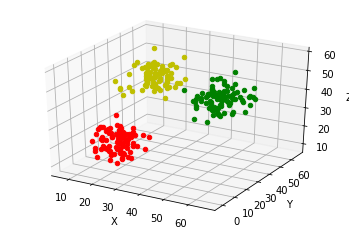

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x, y, z, p in zip(x_test[:,0], x_test[:,1], x_test[:,2], y_test):
    if int(p)==1:
        ax.scatter(x, y, z, c='r')
    elif int(p)==2:
        ax.scatter(x, y, z, c='y')
    else:
        ax.scatter(x, y, z, c='g')
ax.set_zlabel('Z')  # 坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()